In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
from pandas_datareader import data

In [3]:
stock=data.get_data_yahoo('AAPL',start='2016/7/1')
out_file=open('data/aap12016-2.csv','w')
stock.to_csv(out_file)
out_file.close()

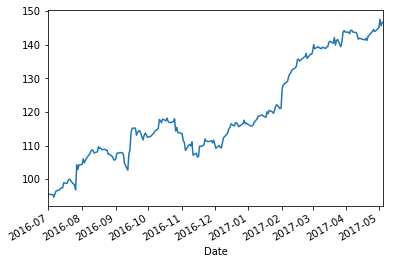

In [4]:
data=pd.read_csv('data/aap12016-2.csv',index_col='Date')
data.index=pd.to_datetime(data.index)
data['Open'].plot()
plt.show()

F:\Anaconda\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


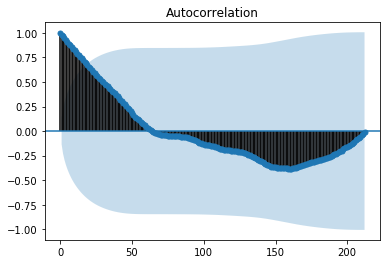

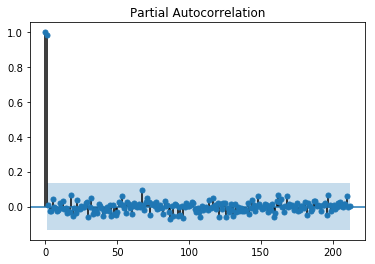

In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data['Open']).show()
plot_pacf(data['Open']).show()

In [6]:
from statsmodels.tsa.stattools import adfuller as ADF
print "原始序列的ADF检验结果为;",ADF(data['Open'])

原始序列的ADF检验结果为; (-0.31873211395060441, 0.92280908552427887, 1L, 211L, {'5%': -2.8753374677799957, '1%': -3.4617274344627398, '10%': -2.5741240890815571}, 680.54683007718938)


In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print "原始数据的白噪声检验结果为：",acorr_ljungbox(data['Open'],lags=1)

原始数据的白噪声检验结果为： (array([ 208.03286175]), array([  3.69019250e-47]))


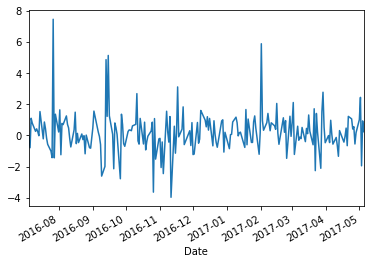

In [8]:
D_data=data['Open'].diff().dropna()
D_data.columns=['diff_open']
D_data.plot()
plt.show()

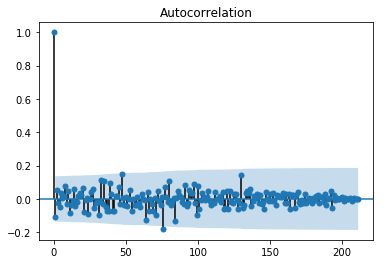

In [9]:
plot_acf(D_data).show()

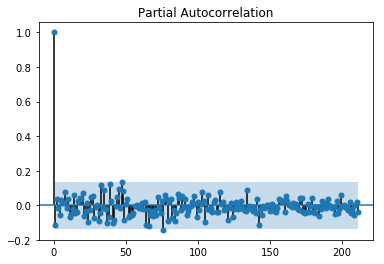

In [10]:
plot_pacf(D_data).show()

In [11]:
#ADF平稳性检验的值<0.05，表示为非平稳序列
print '二阶差分序列的ADF检验结果为：',ADF(D_data)

二阶差分序列的ADF检验结果为： (-16.172104174692674, 4.3539569074225697e-29, 0L, 211L, {'5%': -2.8753374677799957, '1%': -3.4617274344627398, '10%': -2.5741240890815571}, 674.39749858203209)


In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print '二阶差分序列的白噪声检验结果为：',acorr_ljungbox(D_data,lags=1)

二阶差分序列的白噪声检验结果为： (array([ 2.67276277]), array([ 0.10207868]))


In [16]:
from statsmodels.tsa.arima_model import ARIMA

pmax=3
qmax=3
data['Open']=data['Open'].astype(float)

bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:#存在部分报错，所以用try来跳过报错
            tmp.append(ARIMA(data['Open'],(p,2,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
    
bic_matrix=pd.DataFrame(bic_matrix)
p,q=bic_matrix.stack().idxmin()

print 'BIC最小的p值和q值为： %s,%s' % (p,q)

F:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in divide
  R_mat, T_mat)
F:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
F:\Anaconda\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversi

BIC最小的p值和q值为： 0,1


F:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
train=data[:-5]['Open']
test=data[-5:]['Open']

model=ARIMA(train,(p,1,q)).fit()
forecastnum=5
yHat=model.forecast(forecastnum,alpha=0.01)

In [18]:
print yHat[0]
print test

[ 144.33751146  144.57254324  144.80757502  145.04260681  145.27763859]
Date
2017-05-01    145.100006
2017-05-02    147.539993
2017-05-03    145.589996
2017-05-04    146.520004
2017-05-05    146.759995
Name: Open, dtype: float64


In [19]:
def RMSE(yArr,yHatArr):
    return np.sqrt(((yArr-yHatArr)**2).sum())/len(yArr)

In [20]:
from sklearn.metrics import mean_squared_error
print mean_squared_error(yHat[0],test)

2.87588431533


In [21]:
RMSE(test,yHat[0])

0.75840415549054208

In [22]:
def absError(yArr,yHatArr):
    return abs(yArr-yHatArr).sum()/len(yArr)

In [23]:
absError(test,yHat[0])

1.4944237761338173